In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import gc

In [2]:
itemids = [50817,51301,51144,51288,50889,50861,53084,50878,53088,50885,53089,51842,52024,51237,51675,51240,51002,51003,52642,50809,50931,52569,50983,52623,50811,51222,51640,50902,52535,50882,50813,52442,53154,52022,53138,50862,53085,220045,220210,227242,227243,223762,53134,51300,51704,52159,52647,51006,50825]

##### Bases

In [3]:
BASES_HOSP = "/scratch/haniel.botelho/physionet.org/files/mimiciv/2.2/hosp/"
BASES_ICU = "/scratch/haniel.botelho/physionet.org/files/mimiciv/2.2/icu/"
patient = "patients.csv"
admission = "admissions.csv"
diagnostics = "diagnoses_icd.csv"
icd_diagnostics = "d_icd_diagnoses.csv"
lab = "labevents.csv"
lab_items = "d_labitems.csv"
chart_items = "d_items.csv"
chart = "chartevents.csv"
icu = "icustays.csv"
id_dignoses = "d_icd_diagnoses.csv"

url_patient = BASES_HOSP + patient
url_admission = BASES_HOSP + admission
url_diagnostics = BASES_HOSP + diagnostics
url_icd_diagnostics = BASES_HOSP + icd_diagnostics
url_lab = BASES_HOSP + lab
url_lab_items = BASES_HOSP + lab_items
url_chart_items = BASES_HOSP + chart_items
url_chart = BASES_ICU + chart
url_icu = BASES_ICU + icu
url_id_dignoses = BASES_HOSP + id_dignoses

In [9]:
df_chartvents = pd.read_csv(url_chart)


In [10]:
df_selected_chartvents = df_chartvents[df_chartvents['itemid'].isin(itemids)][['subject_id', 'hadm_id','charttime','itemid', 'value']]
del df_chartvents
gc.collect()

0

In [11]:
df_labevents = pd.read_csv(url_lab)


In [12]:
df_selected_labevents = df_labevents[df_labevents['itemid'].isin(itemids)][['subject_id', 'hadm_id','charttime','itemid', 'value']]
del df_labevents
gc.collect()

0

In [29]:
df_admissions = pd.read_csv(url_admission)

In [15]:
df_diagnostics = pd.read_csv(url_diagnostics)

In [16]:
df_id = pd.read_csv(url_id_dignoses)

In [17]:
df_diagnostics = pd.read_csv(url_diagnostics)
df_id = pd.read_csv(url_id_dignoses)
df_diagnostics = pd.merge(df_diagnostics, df_id,how = "inner",on = ["icd_code","icd_version"])
del df_id
gc.collect()

473

In [18]:
df_diagnostics['sepsis'] = df_diagnostics['long_title'].str.contains("sepsis") | df_diagnostics['long_title'].str.contains("Sepsis")


In [19]:
df_diagnostics_sepsis = df_diagnostics[df_diagnostics['sepsis']==True][['subject_id','hadm_id',"sepsis"]]
del df_diagnostics
gc.collect()
df_diagnostics_sepsis

,subject_id,hadm_id,sepsis
128,10000826,21086876,True
498,10001401,27012892,True
499,10001401,27012892,True
503,10001401,27012892,True
514,10001401,27060146,True
...,...,...,...
4752276,19992202,20329411,True
4754791,19997367,20617667,True
4754858,19997367,21508795,True
4755222,19997886,20793010,True


### Caracterização das entradas

In [ ]:
df_admissions = pd.merge(df_admissions,df_diagnostics,how ='inner',on = ['subject_id','hadm_id'])

In [16]:
df_pacientes = pd.DataFrame()
df_pacientes = pd.DataFrame(df_admissions[df_admissions['sepsis'] == True]['subject_id'].drop_duplicates())
df_pacientes['entrada'] = df_admissions[df_admissions['sepsis'] == True].groupby('subject_id').count()['hadm_id'].values
df_pacientes

,subject_id,entrada
128,10000826,1
498,10001401,4
1016,10002013,2
1383,10002428,2
2003,10003019,1
...,...,...
4750696,19988077,1
4751611,19990427,2
4752276,19992202,1
4754791,19997367,2


In [17]:
entradas = pd.DataFrame(df_pacientes['entrada'].value_counts().sort_index()).reset_index()

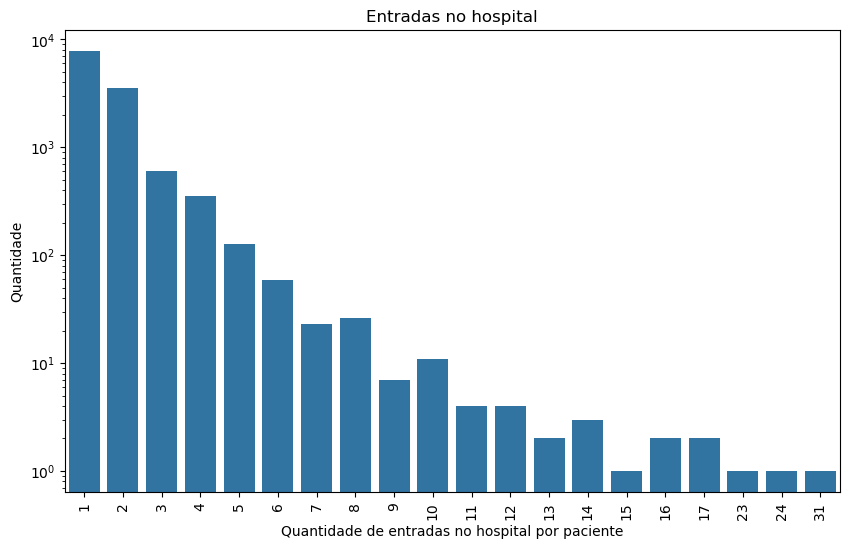

In [18]:
plt.figure(figsize=(10,6))
sns.barplot(x =entradas['entrada'],y=entradas['count'])
plt.yscale('log')
plt.xlabel('Quantidade de entradas no hospital por paciente')
plt.ylabel('Quantidade')
plt.title('Entradas no hospital')
plt.xticks(rotation=90)
plt.show()

In [19]:
bins = np.arange(0,250,10)
labels = np.array([f"{x}-{x+10}" for x in bins])


In [20]:
entradas["groups"] = labels[np.digitize(entradas["entrada"],bins)]
entradas = entradas.groupby("groups").sum().reset_index()


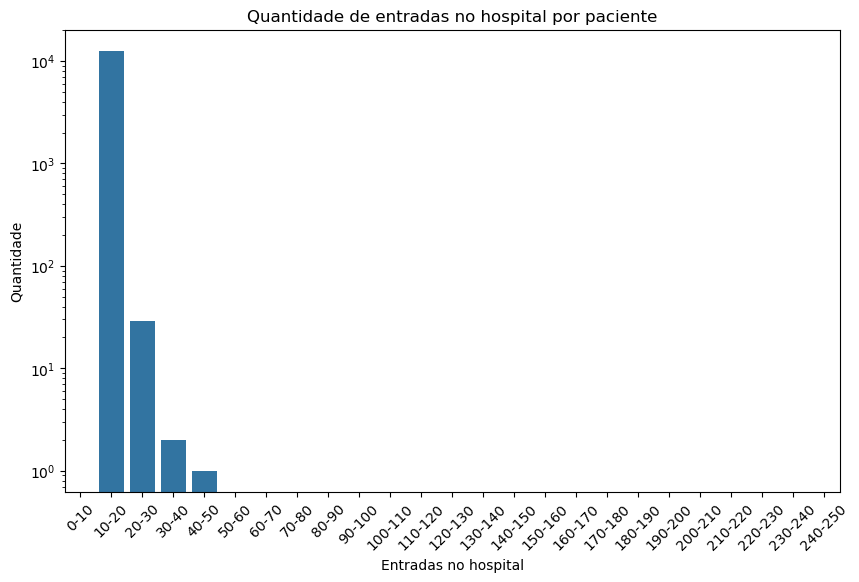

In [22]:
# Plotar os dados binarizados
plt.figure(figsize=(10, 6))
sns.barplot(x=entradas["groups"], y=entradas["count"],order=labels)
plt.yscale('log')
plt.xlabel('Entradas no hospital')
plt.ylabel('Quantidade')
plt.title('Quantidade de entradas no hospital por paciente')
plt.xticks(rotation=45)
plt.show()

### Exames

#### Seleção dos exames

In [34]:
def aggregate_events(df):
    itemid_map = {
        'Albumine': [52022, 53138, 50862, 53085],
        'Lactate': [50813, 52442, 53154],
        'Bicarbonate': [50813, 52442, 53154],
        'Chloride': [50902, 52535],
        'Hemoglobin': [50811, 51222, 51640],
        'Sodium': [50983, 52623],
        'Glucose': [50809, 50931, 52569],
        'Troponin': [51002, 51003, 52642],
        'Platelets': [51240,51704,52159],
        'INR': [51237, 51675],
        'Creatinine': [50813, 52442, 53154],
        'Bun': [51842,52647,51006],
        'Bilirubin': [50885, 53089],
        'AST': [50878, 53088],
        'ALT': [50861, 53084],
        'C_reactive': [50889],
        'ESR': [51288],
        'Bands': [51144],
        'WBC': [51301,53134,51300],
        'Oxygen_saturation': [50817],
        'Temperature': [223762],
        'Systolic_pressure': [227242, 227243],
        'Respiratory_rate': [220210],
        'Heart_rate': [220045]
    }
    
    for key, itemids in itemid_map.items():
        new_col = df['itemid'].isin(itemids) * df["value"]
        new_col[new_col == ""] = np.NaN
        new_col[new_col == "___"] = np.NaN
        df[key] = new_col
    return df


In [24]:
df_exams = pd.concat([df_selected_chartvents,df_selected_labevents],ignore_index=True)


In [25]:
df_exams

,subject_id,hadm_id,charttime,itemid,value
0,10000032,29079034.0,2180-07-23 22:00:00,220045,94
1,10000032,29079034.0,2180-07-23 22:00:00,220210,20
2,10000032,29079034.0,2180-07-23 19:00:00,220045,97
3,10000032,29079034.0,2180-07-23 19:00:00,220210,16
4,10000032,29079034.0,2180-07-23 20:00:00,220045,100
...,...,...,...,...,...
42492328,19999987,23865745.0,2145-11-09 05:30:00,50983,144
42492329,19999987,23865745.0,2145-11-09 05:30:00,51006,8
42492330,19999987,23865745.0,2145-11-09 05:30:00,51222,12.3
42492331,19999987,23865745.0,2145-11-09 05:30:00,51301,5.7


In [26]:
df_exams = pd.merge(df_exams,df_diagnostics_sepsis,on = ['subject_id', 'hadm_id'],how = 'inner')

In [30]:
df_exams = pd.merge(df_exams,df_admissions[['subject_id', 'hadm_id','admittime']],how = 'inner',on=['subject_id', 'hadm_id'])

#### Calculo do offset dos exames

In [31]:
# Convertendo colunas para datetime
df_exams['charttime'] = pd.to_datetime(df_exams['charttime'])
df_exams['admittime'] = pd.to_datetime(df_exams['admittime'])
# Calculando os offsets
df_exams['offsettime'] = df_exams['charttime'] - df_exams['admittime']

In [32]:
df_exams

,subject_id,hadm_id,charttime,itemid,value,sepsis,admittime,offsettime
0,10002428,23473524.0,2156-05-16 07:00:00,220045,86,True,2156-05-11 14:49:00,4 days 16:11:00
1,10002428,23473524.0,2156-05-16 07:00:00,220210,14,True,2156-05-11 14:49:00,4 days 16:11:00
2,10002428,23473524.0,2156-05-16 08:00:00,220045,84,True,2156-05-11 14:49:00,4 days 17:11:00
3,10002428,23473524.0,2156-05-16 08:00:00,220210,15,True,2156-05-11 14:49:00,4 days 17:11:00
4,10002428,23473524.0,2156-05-16 09:00:00,220045,83,True,2156-05-11 14:49:00,4 days 18:11:00
...,...,...,...,...,...,...,...,...
8490262,19997886,20793010.0,2186-12-10 07:58:00,50983,150,True,2186-11-12 07:10:00,28 days 00:48:00
8490263,19997886,20793010.0,2186-12-10 07:58:00,51006,28,True,2186-11-12 07:10:00,28 days 00:48:00
8490264,19997886,20793010.0,2186-12-10 07:58:00,51006,28,True,2186-11-12 07:10:00,28 days 00:48:00
8490265,19997886,20793010.0,2186-12-10 10:32:00,50813,___,True,2186-11-12 07:10:00,28 days 03:22:00


In [35]:
df_exams = aggregate_events(df_exams)
df_exams.drop(['itemid','value'],axis = 1,inplace = True)

In [36]:
df_exams

,subject_id,hadm_id,charttime,sepsis,admittime,offsettime,Albumine,Lactate,Bicarbonate,Chloride,...,ALT,C_reactive,ESR,Bands,WBC,Oxygen_saturation,Temperature,Systolic_pressure,Respiratory_rate,Heart_rate
0,10002428,23473524.0,2156-05-16 07:00:00,True,2156-05-11 14:49:00,4 days 16:11:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86
1,10002428,23473524.0,2156-05-16 07:00:00,True,2156-05-11 14:49:00,4 days 16:11:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14,NaN
2,10002428,23473524.0,2156-05-16 08:00:00,True,2156-05-11 14:49:00,4 days 17:11:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84
3,10002428,23473524.0,2156-05-16 08:00:00,True,2156-05-11 14:49:00,4 days 17:11:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,NaN
4,10002428,23473524.0,2156-05-16 09:00:00,True,2156-05-11 14:49:00,4 days 18:11:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8490262,19997886,20793010.0,2186-12-10 07:58:00,True,2186-11-12 07:10:00,28 days 00:48:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8490263,19997886,20793010.0,2186-12-10 07:58:00,True,2186-11-12 07:10:00,28 days 00:48:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8490264,19997886,20793010.0,2186-12-10 07:58:00,True,2186-11-12 07:10:00,28 days 00:48:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8490265,19997886,20793010.0,2186-12-10 10:32:00,True,2186-11-12 07:10:00,28 days 03:22:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
df_exams['days'] = (df_exams['offsettime'].dt.total_seconds()//(60*60*24)).values.astype(int)
df_exams['hours'] = (df_exams['offsettime'].dt.total_seconds()//(60*60)).values.astype(int)

#### Visualização

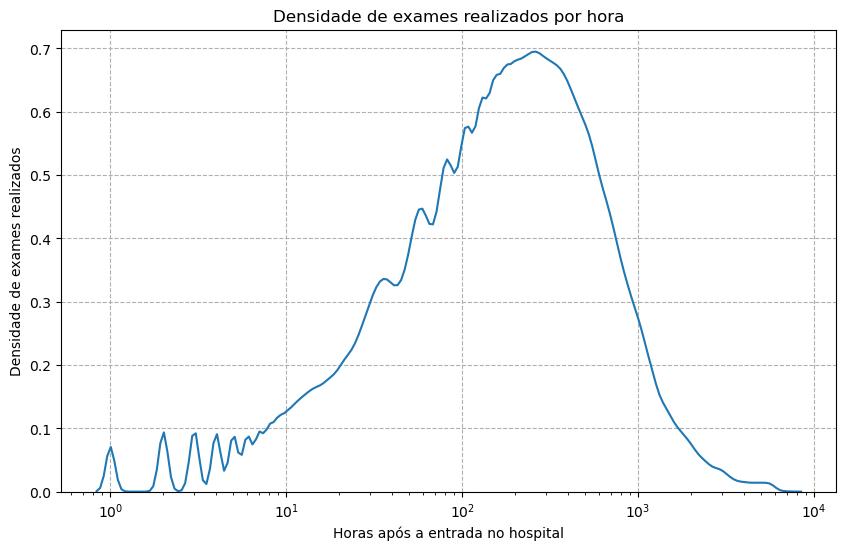

In [38]:
# Criar o gráfico de linhas
plt.figure(figsize=(10,6))
sns.kdeplot(df_exams[df_exams['hours']>0]['hours'], log_scale=True)
plt.xlabel('Horas após a entrada no hospital')
plt.ylabel('Densidade de exames realizados')
plt.title('Densidade de exames realizados por hora')
plt.grid(True, which="major", ls="--")
plt.show()


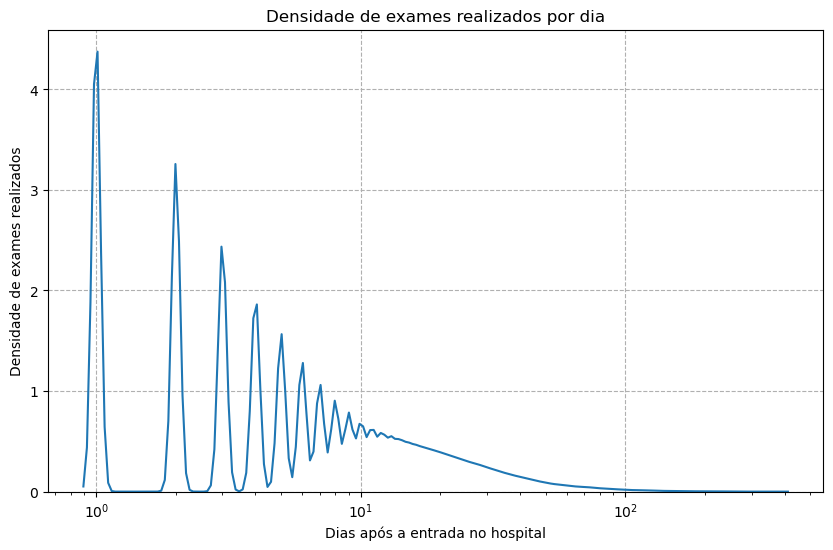

In [22]:
# Criar o gráfico de linhas
plt.figure(figsize=(10,6))
sns.kdeplot(df_exams[df_exams['days']>0]['days'], log_scale=True)
plt.xlabel('Dias após a entrada no hospital')
plt.ylabel('Densidade de exames realizados')
plt.title('Densidade de exames realizados por dia')
plt.grid(True, which="major", ls="--")
plt.show()


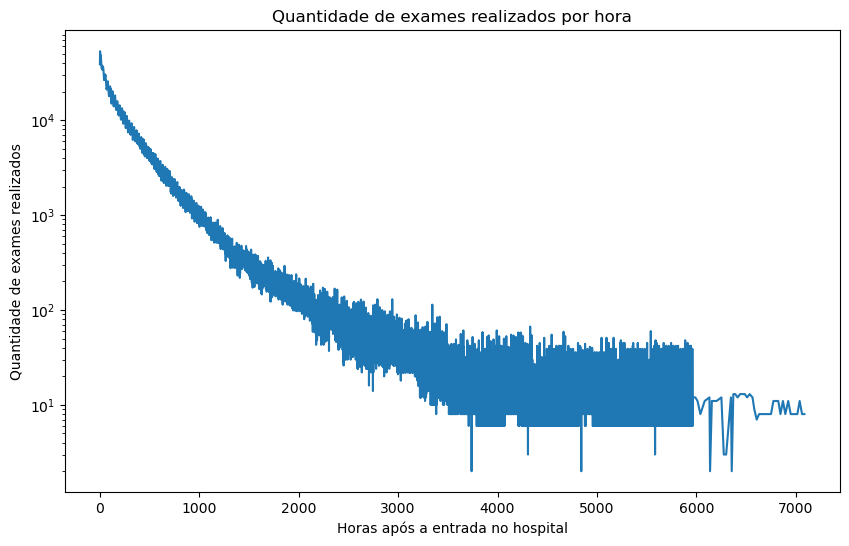

In [39]:
hourly_counts = df_exams[df_exams['hours']>0]['hours'].value_counts().sort_index()

# Criar o gráfico de linhas com o eixo y em escala logarítmica
plt.figure(figsize=(10, 6))
plt.plot(hourly_counts.index, hourly_counts.values)
plt.yscale('log')
plt.xlabel('Horas após a entrada no hospital')
plt.ylabel('Quantidade de exames realizados')
plt.title('Quantidade de exames realizados por hora')
plt.show()

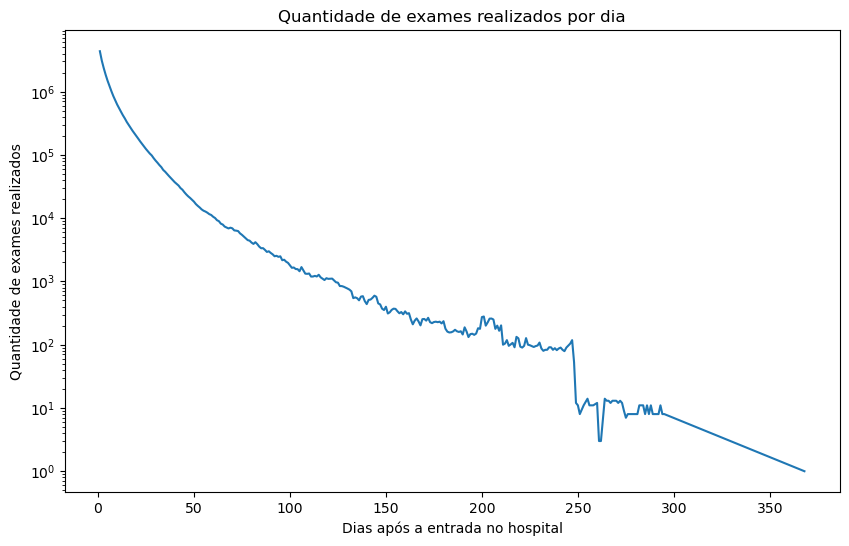

In [24]:
days_counts = df_exams[df_exams['days']>0]['days'].value_counts().sort_index()

# Criar o gráfico de linhas com o eixo y em escala logarítmica
plt.figure(figsize=(10, 6))
plt.plot(days_counts.index, days_counts.values)
plt.yscale('log')
plt.xlabel('Dias após a entrada no hospital')
plt.ylabel('Quantidade de exames realizados')
plt.title('Quantidade de exames realizados por dia')
plt.show()

In [44]:
df_diagnostics_sepsis

,subject_id,hadm_id,sepsis
128,10000826,21086876,True
498,10001401,27012892,True
499,10001401,27012892,True
503,10001401,27012892,True
514,10001401,27060146,True
...,...,...,...
4752276,19992202,20329411,True
4754791,19997367,20617667,True
4754858,19997367,21508795,True
4755222,19997886,20793010,True


In [45]:
df_admissions = pd.merge(df_admissions[['subject_id','hadm_id']],df_diagnostics_sepsis,how='inner',on = ['subject_id','hadm_id'])
df_admissions

,subject_id,hadm_id,sepsis
0,10000826,21086876,True
1,10001401,27012892,True
2,10001401,27012892,True
3,10001401,27012892,True
4,10001401,27060146,True
...,...,...,...
20012,19992202,20329411,True
20013,19997367,20617667,True
20014,19997367,21508795,True
20015,19997886,20793010,True


#### Cálculo dos nulos


In [46]:
def stats(delta):
    df_exams_filtrado = df_exams[df_exams['admittime']!= 'NaT']
    df_stats = df_exams_filtrado[(df_exams_filtrado['hours']>0) & (df_exams_filtrado['hours']<=delta)]
    pacientes_que_fizeram_exame = df_stats.groupby(['subject_id','hadm_id']).apply(lambda x: x.notna().any(),include_groups=False)
    qtd_pacientes_que_fizeram_exame = pacientes_que_fizeram_exame.sum()

    total_patients = len(df_admissions[['subject_id','hadm_id']])
    df_stats = pd.DataFrame((total_patients-qtd_pacientes_que_fizeram_exame)/total_patients).reset_index()
    df_stats.columns = ["exams","porcentagem_de_nulos"]
    return df_stats["exams"],df_stats["porcentagem_de_nulos"]

In [47]:
def tratamento(df):
    df.loc[:,df.columns!="exams"] *= 100
    df.loc[:,df.columns!="exams"] = df.loc[:,df.columns!="exams"].round(2)
    df.loc[:,df.columns!="exams"] = df.loc[:,df.columns!="exams"].astype(str) + '%'
    return df


In [48]:
colunas,null_stats = stats(24)
df_stats = pd.DataFrame(colunas)
df_stats["porcentagem_de_nulos_24h"] = null_stats
_,null_stats = stats(48) 
df_stats["porcentagem_de_nulos_48h"] = null_stats
_,null_stats = stats(72)
df_stats["porcentagem_de_nulos_72h"] = null_stats
df_stats = tratamento(df_stats)
df_stats

/tmp/ipykernel_426987/2011754202.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['24.22%' '24.22%' '24.22%' '24.22%' '74.23%' '62.66%' '62.66%' '26.72%'
 '26.35%' '40.83%' '85.86%' '100.0%' '100.0%' '46.03%' '62.66%' '26.2%'
 '56.18%' '57.3%' '57.06%' '98.87%' '98.91%' '86.45%' '27.77%' '85.38%'
 '96.42%' '99.78%' '57.54%' '57.53%' '24.22%' '24.22%']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:,df.columns!="exams"] = df.loc[:,df.columns!="exams"].astype(str) + '%'
/tmp/ipykernel_426987/2011754202.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['22.82%' '22.82%' '22.82%' '22.82%' '66.48%' '57.98%' '57.98%' '23.97%'
 '23.46%' '38.1%' '83.86%' '100.0%' '100.0%' '38.74%' '57.98%' '23.6%'
 '49.17%' '49.81%' '49.73%' '98.21%' '98.42%' '83.27%' '24.28%' '82.57%'
 '95.59%' '99.73%' '55.4

,exams,porcentagem_de_nulos_24h,porcentagem_de_nulos_48h,porcentagem_de_nulos_72h
0,charttime,24.22%,22.82%,22.75%
1,sepsis,24.22%,22.82%,22.75%
2,admittime,24.22%,22.82%,22.75%
3,offsettime,24.22%,22.82%,22.75%
4,Albumine,74.23%,66.48%,62.6%
5,Lactate,62.66%,57.98%,55.59%
6,Bicarbonate,62.66%,57.98%,55.59%
7,Chloride,26.72%,23.97%,23.74%
8,Hemoglobin,26.35%,23.46%,23.36%
9,Sodium,40.83%,38.1%,37.68%
